<a href="https://colab.research.google.com/github/insarov2014/Heart-Attack-Possibility/blob/main/protein_selection_mice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal of this project is to find a way to select an optimal subset of 77 proteins measured in the cerebral cortex of 8 classes of control and Down syndrome mice exposed to context fear conditionin.

A straight forward strategy is to take the advantage of Random Forest to select important features, and then build a predictive model based on the chosen features for unseen data.

An alternative ways is to use PCA to reduce the features and then build a predictive model based on the new features which contain the majority of the original information in the  orginial features. The weakness is that I cannot tell which protein distinguishes the classes as each new feature is a linear combination of the original features.

Finally, I compare the results from the two predictive models. For the sake of fairness, I used Random Forest Classification with the same space for the same set of hyperparameters.

# Import necessary packages

In [1]:
# Import python modules
import pandas as pd
import numpy as np
import re
import seaborn as sns
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pip install ucimlrepo

#Import data

Data Source: https://archive.ics.uci.edu/dataset/342/mice+protein+expression

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
mice_protein_expression = fetch_ucirepo(id=342)

# data (as pandas dataframes)
X = mice_protein_expression.data.features
y = mice_protein_expression.data.targets

# metadata
print(mice_protein_expression.metadata)

# variable information
print(mice_protein_expression.variables)

{'uci_id': 342, 'name': 'Mice Protein Expression', 'repository_url': 'https://archive.ics.uci.edu/dataset/342/mice+protein+expression', 'data_url': 'https://archive.ics.uci.edu/static/public/342/data.csv', 'abstract': 'Expression levels of 77 proteins measured in the cerebral cortex of 8 classes of control and Down syndrome mice exposed to context fear conditioning, a task used to assess associative learning.', 'area': 'Biology', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate'], 'num_instances': 1080, 'num_features': 80, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': ['MouseID'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2015, 'last_updated': 'Tue Apr 16 2024', 'dataset_doi': '10.24432/C50S3Z', 'creators': ['Clara Higuera', 'Katheleen Gardiner', 'Krzysztof Cios'], 'intro_paper': {'ID': 475, 'type': 'NATIVE', 'title': 'Self-Organizing Feature Maps Identify Proteins Critical

The provider of the data source explained that "The aim is to identify subsets of proteins that are discriminant between the classes." Thus, I only use the protain information in my model.


In [4]:
y.head()

class
0  c-CS-m
1  c-CS-m
2  c-CS-m
3  c-CS-m
4  c-CS-m

In [5]:
X.head()

DYRK1A_N   ITSN1_N    BDNF_N     NR1_N    NR2A_N    pAKT_N   pBRAF_N  \
0  0.503644  0.747193  0.430175  2.816329  5.990152  0.218830  0.177565   
1  0.514617  0.689064  0.411770  2.789514  5.685038  0.211636  0.172817   
2  0.509183  0.730247  0.418309  2.687201  5.622059  0.209011  0.175722   
3  0.442107  0.617076  0.358626  2.466947  4.979503  0.222886  0.176463   
4  0.434940  0.617430  0.358802  2.365785  4.718679  0.213106  0.173627   

   pCAMKII_N   pCREB_N    pELK_N  ...     pS6_N   pCFOS_N     SYP_N  \
0   2.373744  0.232224  1.750936  ...  0.106305  0.108336  0.427099   
1   2.292150  0.226972  1.596377  ...  0.106592  0.104315  0.441581   
2   2.283337  0.230247  1.561316  ...  0.108303  0.106219  0.435777   
3   2.152301  0.207004  1.595086  ...  0.103184  0.111262  0.391691   
4   2.134014  0.192158  1.504230  ...  0.104784  0.110694  0.434154   

   H3AcK18_N    EGR1_N  H3MeK4_N    CaNA_N  Genotype  Treatment  Behavior  
0   0.114783  0.131790  0.128186  1.675652   Control  Memantine       C/S  
1   0.111974  0.135103  0.131119  1.743610   Control  Memantine       C/S  
2   0.111883  0.133362  0.127431  1.926427   Control  Memantine       C/S  
3   0.130405  0.147444  0.146901  1.700563   Control  Memantine       C/S  
4   0.118481  0.140314  0.148380  1.839730   Control  Memantine       C/S  

[5 rows x 80 columns]

In [6]:
X.shape

(1080, 80)

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DYRK1A_N         1077 non-null   float64
 1   ITSN1_N          1077 non-null   float64
 2   BDNF_N           1077 non-null   float64
 3   NR1_N            1077 non-null   float64
 4   NR2A_N           1077 non-null   float64
 5   pAKT_N           1077 non-null   float64
 6   pBRAF_N          1077 non-null   float64
 7   pCAMKII_N        1077 non-null   float64
 8   pCREB_N          1077 non-null   float64
 9   pELK_N           1077 non-null   float64
 10  pERK_N           1077 non-null   float64
 11  pJNK_N           1077 non-null   float64
 12  PKCA_N           1077 non-null   float64
 13  pMEK_N           1077 non-null   float64
 14  pNR1_N           1077 non-null   float64
 15  pNR2A_N          1077 non-null   float64
 16  pNR2B_N          1077 non-null   float64
 17  pPKCAB_N      

There are missing values in X, I'll impute missing values later.

In [8]:
y['class'].unique()

array(['c-CS-m', 'c-SC-m', 'c-CS-s', 'c-SC-s', 't-CS-m', 't-SC-m',
       't-CS-s', 't-SC-s'], dtype=object)

The values of the target column represent the values in
the categorical columns in X.

In [9]:
X['Genotype'].value_counts()

Genotype
Control    570
Ts65Dn     510
Name: count, dtype: int64

In [10]:
X['Treatment'].value_counts()

Treatment
Memantine    570
Saline       510
Name: count, dtype: int64

In [11]:
X['Behavior'].value_counts()

Behavior
S/C    555
C/S    525
Name: count, dtype: int64

Apparently, the 3 categorical columns are directly related to the class column. I won't use the 3 columns in the prediction.

In [12]:
pd.crosstab(X['Genotype'], X['Treatment'])

Treatment  Memantine  Saline
Genotype                    
Control          300     270
Ts65Dn           270     240

In [13]:
pd.crosstab(X['Genotype'], X['Behavior'])

Behavior  C/S  S/C
Genotype          
Control   285  285
Ts65Dn    240  270

In [14]:
pd.crosstab(X['Treatment'], X['Behavior'])

Behavior   C/S  S/C
Treatment          
Memantine  285  285
Saline     240  270

The cross tab tables show that each group for the pairwise categorical features are relatively balanced.

## Impute missing values

I decide to replace the missing values in each numerical feature with its corresponding mean.

In [15]:
# impute missing values
from sklearn.impute import SimpleImputer
X_num = X[X.columns[:-3].values]
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_num)
X_num_new = imputer.transform(X_num)
X_num_new = pd.DataFrame(X_num_new, columns=X_num.columns, index=X_num.index)

# Check Multicollinearity

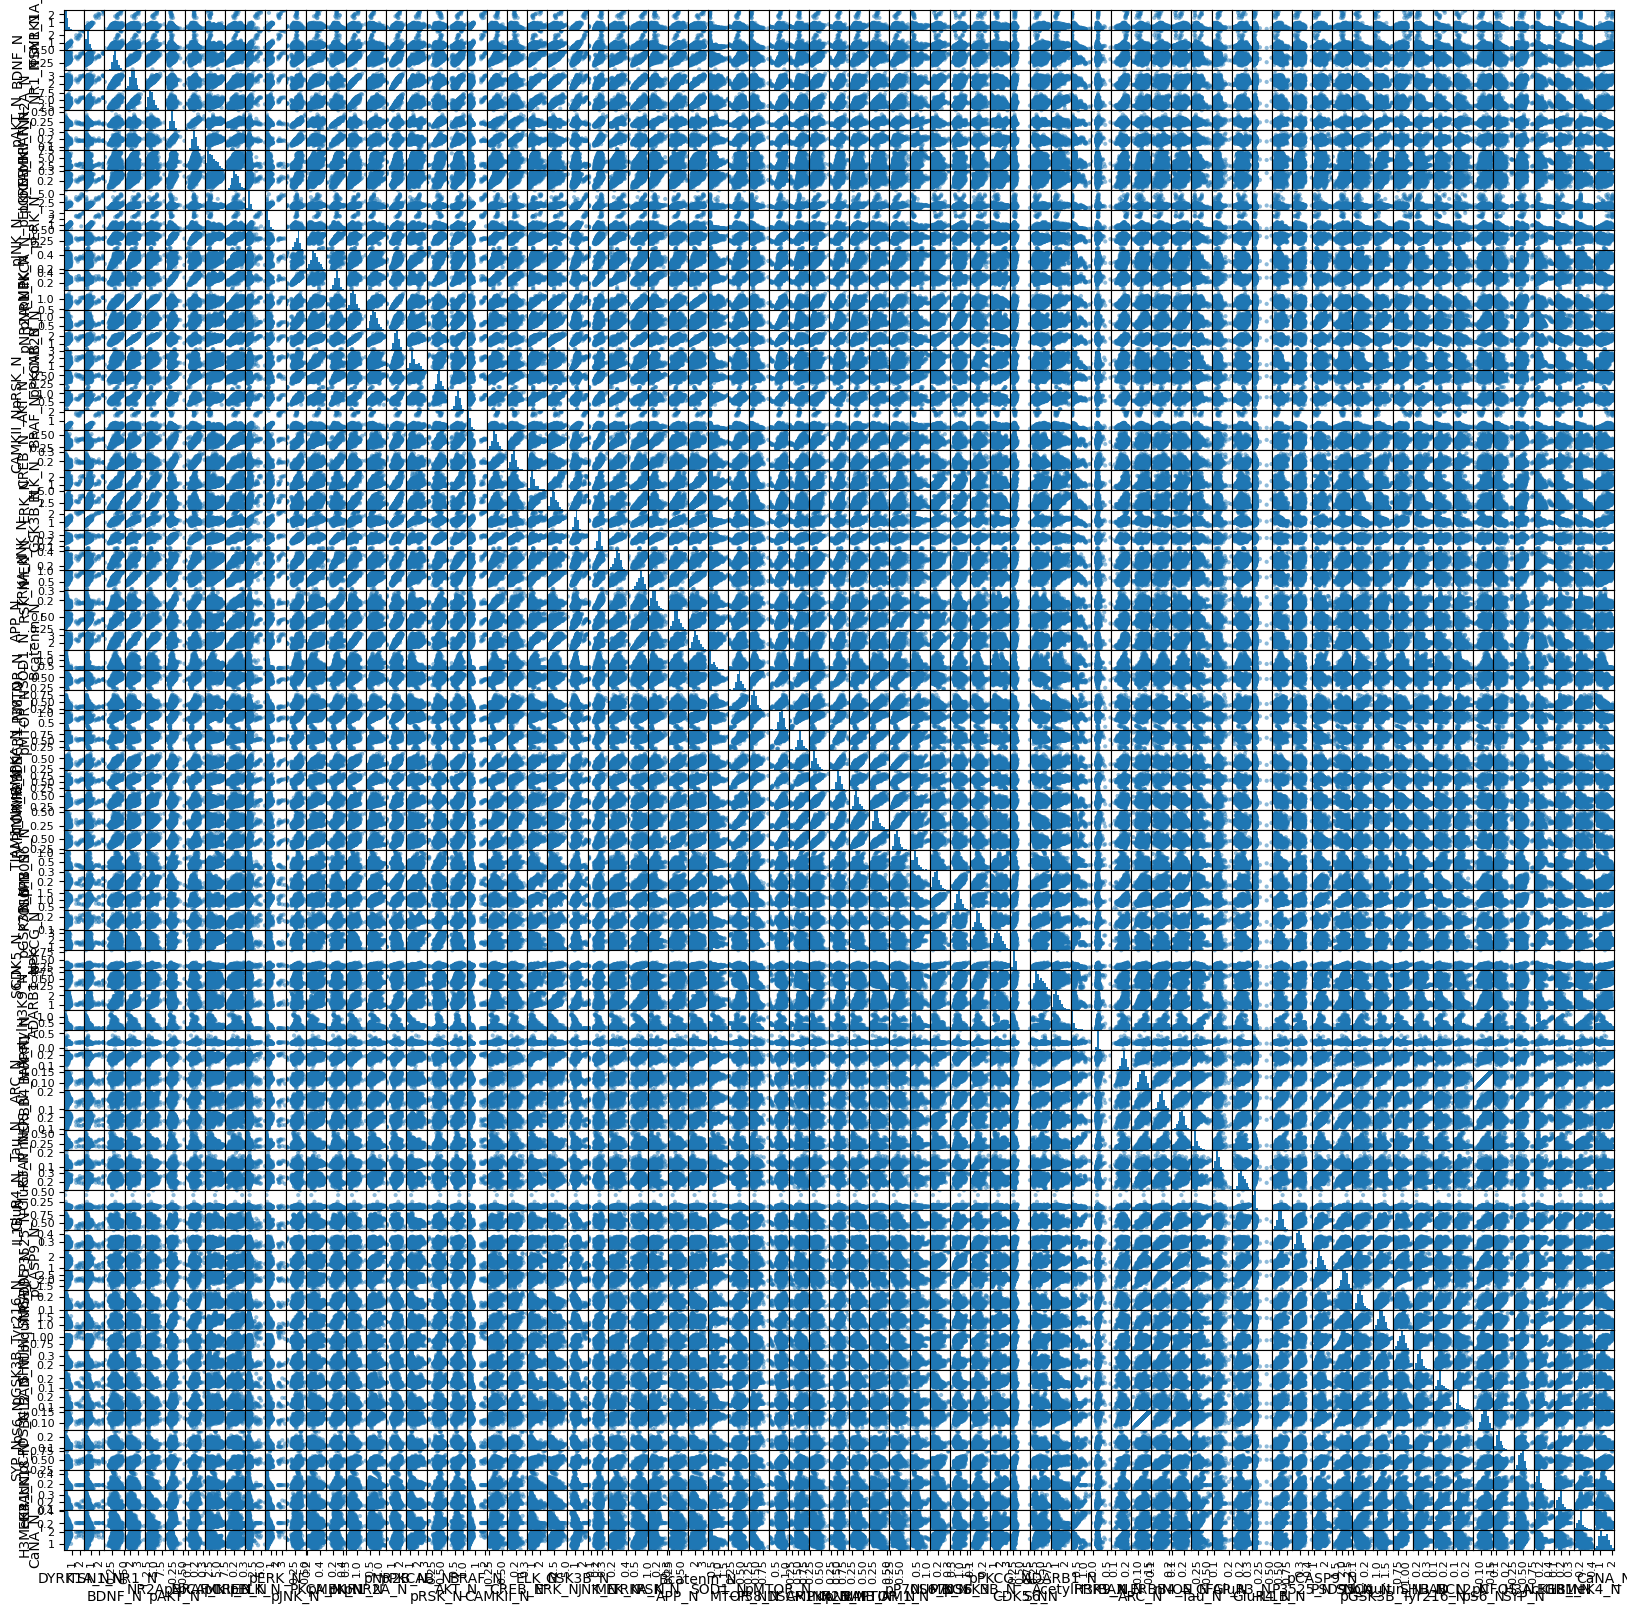

CPU times: user 26min 7s, sys: 11.4 s, total: 26min 18s
Wall time: 26min 25s


In [17]:
%%time
from pandas.plotting import scatter_matrix

# histograms and scatter plots.
scatter_matrix(X_num_new, figsize=(20, 20))
# plt.figure(figsize=(20, 20))
# sns.pairplot(X_num_new)
plt.show()

CPU times: user 830 ms, sys: 93 ms, total: 923 ms
Wall time: 831 ms


<Axes: >

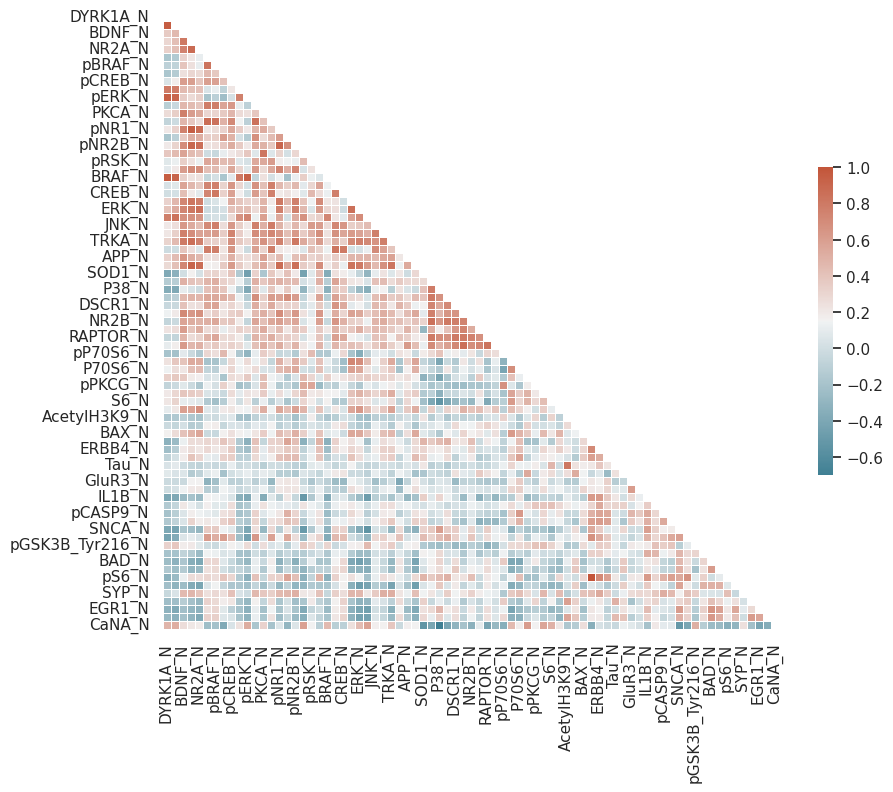

In [18]:
%%time

sns.set_theme(style="white")

# to compute the correlation matrix
corr = (X_num_new).corr()

# to generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# to set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# to generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# to draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5})

So many pairs of proteins are correlated! If I combine two correlated proteins or delete one of correlated proteins for each pair, I must do this for almost half of the proteins. Recall the characteristics of Random Forest -- it splits the nodes by considering the features that will achieve the largest loss -- implies if a feature is used at the current split then its corresponding correlated feature might be used less likely. Thus, I will keep all the proteins and use Random Forest to select important features.

#Train data, validation data and test data

The good news is no missing values exist in the target column.

In [19]:
y.isna().sum()

class    0
dtype: int64

The classes in y column are relatively balanced, thus, I don't bother to do upsampling or downsampling in order to obtain a balanced dataset.

In [20]:
y['class'].value_counts()

class
c-CS-m    150
c-SC-m    150
c-CS-s    135
c-SC-s    135
t-CS-m    135
t-SC-m    135
t-SC-s    135
t-CS-s    105
Name: count, dtype: int64

I will split the raw X into two subsets --- big training set and test set, then I will seperate the big training set intwo two subsets --- small training set and validation set.

Step 1: Train data and test data

In [21]:
# The ratio of train data to test data is 80:20
stratifiedSample = np.ceil(y['class'].value_counts()*0.8).astype(int)
stratifiedSample

class
c-CS-m    120
c-SC-m    120
c-CS-s    108
c-SC-s    108
t-CS-m    108
t-SC-m    108
t-SC-s    108
t-CS-s     84
Name: count, dtype: int64

In [22]:
sample_size = dict(zip(stratifiedSample.index.values,stratifiedSample.values))
sample_size

{'c-CS-m': 120,
 'c-SC-m': 120,
 'c-CS-s': 108,
 'c-SC-s': 108,
 't-CS-m': 108,
 't-SC-m': 108,
 't-SC-s': 108,
 't-CS-s': 84}

I build a function to obtain the index for the samples chosen from a data set.

In [23]:
def get_index(data, sample_size, randomSeed):
  index_list = []

  for i in sample_size.keys():
    index_list += list(data[data['class']==i].sample(sample_size[i], random_state=randomSeed).index.values)

  return index_list

In [24]:
# to split y according to the size of the classes of y
random.seed(42)
chosen_index = get_index(y, sample_size, randomSeed=28)
len(chosen_index)

864

In [25]:
y_train = y.loc[chosen_index]
y_train

class
24   c-CS-m
134  c-CS-m
81   c-CS-m
14   c-CS-m
114  c-CS-m
..      ...
908  t-CS-s
910  t-CS-s
877  t-CS-s
936  t-CS-s
874  t-CS-s

[864 rows x 1 columns]

In [26]:
y_test = y.loc[~y.index.isin(chosen_index)]
y_test['class'].value_counts()

class
c-CS-m    30
c-SC-m    30
c-CS-s    27
c-SC-s    27
t-CS-m    27
t-SC-m    27
t-SC-s    27
t-CS-s    21
Name: count, dtype: int64

In [27]:
X_train = X_num_new.loc[chosen_index]
X_train

DYRK1A_N   ITSN1_N    BDNF_N     NR1_N    NR2A_N    pAKT_N   pBRAF_N  \
24   0.550970  0.561356  0.320853  2.197868  3.558896  0.237770  0.194589   
134  0.515372  0.681675  0.308158  2.190753  3.023239  0.272573  0.214476   
81   0.494053  0.666165  0.311962  2.439781  4.256596  0.225564  0.157485   
14   0.374410  0.462313  0.344629  1.861162  3.287123  0.221811  0.185459   
114  0.317655  0.463011  0.284330  1.981565  3.203498  0.227369  0.200662   
..        ...       ...       ...       ...       ...       ...       ...   
908  0.721025  0.767548  0.290728  2.149200  3.760855  0.213026  0.158341   
910  0.471246  0.631332  0.247882  1.872363  3.117902  0.173427  0.138093   
877  0.416656  0.655634  0.271283  1.969416  3.038263  0.173573  0.137561   
936  0.451539  0.677385  0.299756  2.125114  3.572691  0.207711  0.169765   
874  0.435862  0.718732  0.288591  2.035588  3.275432  0.178052  0.142923   

     pCAMKII_N   pCREB_N    pELK_N  ...     SHH_N     BAD_N    BCL2_N  \
24    1.783821  0.178191  1.831375  ...  0.218912  0.193632  0.198961   
134   2.932704  0.205035  1.369644  ...  0.294942  0.210374  0.159794   
81    3.728230  0.190021  1.309091  ...  0.223662  0.149873  0.104206   
14    1.444239  0.176422  1.123023  ...  0.193840  0.183954  0.134762   
114   1.912314  0.199480  1.157646  ...  0.236375  0.189349  0.134762   
..         ...       ...       ...  ...       ...       ...       ...   
908   1.913973  0.166830  1.780934  ...  0.192204  0.123709  0.113638   
910   1.555075  0.163512  1.411394  ...  0.173766  0.132640  0.113321   
877   2.260294  0.189196  1.197140  ...  0.224950  0.151817  0.122408   
936   2.346693  0.192777  1.200853  ...  0.218036  0.171886  0.135080   
874   2.588626  0.214327  1.274173  ...  0.242504  0.150774  0.117237   

        pS6_N   pCFOS_N     SYP_N  H3AcK18_N    EGR1_N  H3MeK4_N    CaNA_N  
24   0.104263  0.131053  0.430309   0.170812  0.228614  0.233124  1.077480  
134  0.103415  0.153834  0.482603   0.206347  0.206024  0.205440  1.553157  
81   0.113798  0.116340  0.443060   0.115848  0.146265  0.150857  1.541363  
14   0.099140  0.125788  0.446562   0.160602  0.227937  0.224212  1.613897  
114  0.123793  0.135628  0.521021   0.169609  0.183135  0.258954  1.459670  
..        ...       ...       ...        ...       ...       ...       ...  
908  0.113552  0.119455  0.354371   0.103828  0.157305  0.166247  1.384408  
910  0.092193  0.136821  0.284262   0.101231  0.172184  0.139532  0.974579  
877  0.104711  0.130476  0.377895   0.218010  0.158931  0.224863  1.386571  
936  0.108777  0.133057  0.528375   0.182195  0.191155  0.208883  1.741016  
874  0.112761  0.130809  0.392355   0.219127  0.159443  0.224101  1.459002  

[864 rows x 77 columns]

In [28]:
X_test = X_num_new.loc[~X_num_new.index.isin(chosen_index)]
X_test.head()

DYRK1A_N   ITSN1_N    BDNF_N     NR1_N    NR2A_N    pAKT_N   pBRAF_N  \
1  0.514617  0.689064  0.411770  2.789514  5.685038  0.211636  0.172817   
3  0.442107  0.617076  0.358626  2.466947  4.979503  0.222886  0.176463   
4  0.434940  0.617430  0.358802  2.365785  4.718679  0.213106  0.173627   
5  0.447506  0.628176  0.367388  2.385939  4.807635  0.218578  0.176233   
7  0.416923  0.564036  0.327703  2.260135  4.268735  0.214834  0.179668   

   pCAMKII_N   pCREB_N    pELK_N  ...     SHH_N     BAD_N    BCL2_N     pS6_N  \
1   2.292150  0.226972  1.596377  ...  0.200404  0.116682  0.134762  0.106592   
3   2.152301  0.207004  1.595086  ...  0.192112  0.132781  0.134762  0.103184   
4   2.134014  0.192158  1.504230  ...  0.205604  0.129954  0.134762  0.104784   
5   2.141282  0.195188  1.442398  ...  0.190469  0.131575  0.134762  0.106476   
7   2.007985  0.189803  1.424601  ...  0.191561  0.141013  0.134762  0.099494   

    pCFOS_N     SYP_N  H3AcK18_N    EGR1_N  H3MeK4_N    CaNA_N  
1  0.104315  0.441581   0.111974  0.135103  0.131119  1.743610  
3  0.111262  0.391691   0.130405  0.147444  0.146901  1.700563  
4  0.110694  0.434154   0.118481  0.140314  0.148380  1.839730  
5  0.109446  0.439833   0.116657  0.140766  0.142180  1.816389  
7  0.113080  0.382532   0.123376  0.155612  0.159409  1.652658  

[5 rows x 77 columns]

Step 2: Split big train data into two sets: small training data and validation data

In [29]:
# The ratio of small training set to validation set is 80:20
train_val_Sample = np.ceil(y_train['class'].value_counts()*0.8).astype(int)
train_val_Sample

class
c-CS-m    96
c-SC-m    96
c-CS-s    87
c-SC-s    87
t-CS-m    87
t-SC-m    87
t-SC-s    87
t-CS-s    68
Name: count, dtype: int64

In [30]:
train_val_size = dict(zip(train_val_Sample.index.values, train_val_Sample.values))
train_val_size

{'c-CS-m': 96,
 'c-SC-m': 96,
 'c-CS-s': 87,
 'c-SC-s': 87,
 't-CS-m': 87,
 't-SC-m': 87,
 't-SC-s': 87,
 't-CS-s': 68}

In [31]:
# to split y according to the size of the classes of y
random.seed(42)
train_val_index = get_index(y_train, train_val_size, randomSeed=28)
len(train_val_index)

695

In [32]:
Y_training = y_train.loc[train_val_index]
Y_training

class
149  c-CS-m
75   c-CS-m
123  c-CS-m
103  c-CS-m
135  c-CS-m
..      ...
910  t-CS-s
866  t-CS-s
860  t-CS-s
842  t-CS-s
896  t-CS-s

[695 rows x 1 columns]

In [33]:
Y_val = y_train.loc[~y_train.index.isin(train_val_index)]
Y_val['class'].value_counts()

class
c-CS-m    24
c-SC-m    24
c-CS-s    21
c-SC-s    21
t-CS-m    21
t-SC-m    21
t-SC-s    21
t-CS-s    16
Name: count, dtype: int64

In [34]:
X_small_train = X_train.loc[train_val_index]
X_small_train

DYRK1A_N   ITSN1_N    BDNF_N     NR1_N    NR2A_N    pAKT_N   pBRAF_N  \
149  0.472849  0.639933  0.306182  2.059733  3.396617  0.252089  0.200292   
75   0.649781  0.828696  0.405862  2.921435  5.167979  0.207174  0.176640   
123  0.669722  0.911734  0.369172  2.754584  4.451807  0.259560  0.189366   
103  0.246493  0.361698  0.236207  1.711053  2.545540  0.173181  0.155975   
135  0.784226  1.003803  0.441882  2.705605  4.760086  0.222057  0.196015   
..        ...       ...       ...       ...       ...       ...       ...   
910  0.471246  0.631332  0.247882  1.872363  3.117902  0.173427  0.138093   
866  0.324104  0.552117  0.288274  1.905863  2.654723  0.228339  0.157166   
860  0.457483  0.728561  0.304108  2.213548  3.558131  0.234086  0.172952   
842  0.518612  0.733233  0.356137  2.330148  4.631455  0.272468  0.186284   
896  0.718856  0.935593  0.282203  2.070975  3.163559  0.216314  0.160381   

     pCAMKII_N   pCREB_N    pELK_N  ...     SHH_N     BAD_N    BCL2_N  \
149   4.327903  0.197786  1.391186  ...  0.242087  0.146868  0.110317   
75    3.728084  0.239283  1.666579  ...  0.239752  0.139052  0.112926   
123   4.027894  0.223023  1.611184  ...  0.230202  0.152339  0.099987   
103   2.377034  0.140827  0.813727  ...  0.279612  0.190955  0.137832   
135   3.923115  0.277695  1.932788  ...  0.256183  0.120764  0.093610   
..         ...       ...       ...  ...       ...       ...       ...   
910   1.555075  0.163512  1.411394  ...  0.173766  0.132640  0.113321   
866   3.614007  0.204886  1.149674  ...  0.277908  0.180495  0.139290   
860   4.287653  0.259548  1.338938  ...  0.237623  0.165580  0.127236   
842   2.624078  0.192656  1.809524  ...  0.210940  0.156330  0.142243   
896   2.237712  0.207415  2.002542  ...  0.211218  0.134997  0.134762   

        pS6_N   pCFOS_N     SYP_N  H3AcK18_N    EGR1_N  H3MeK4_N    CaNA_N  
149  0.105284  0.085419  0.430274   0.125017  0.148060  0.184082  1.473050  
75   0.132001  0.129363  0.486912   0.125152  0.146865  0.143517  1.627181  
123  0.127691  0.110617  0.459806   0.154996  0.158916  0.205440  1.676654  
103  0.103912  0.160804  0.366475   0.172828  0.212850  0.212491  1.146267  
135  0.123889  0.104568  0.466332   0.119268  0.130798  0.134363  1.461403  
..        ...       ...       ...        ...       ...       ...       ...  
910  0.092193  0.136821  0.284262   0.101231  0.172184  0.139532  0.974579  
866  0.110402  0.160788  0.436233   0.183742  0.164147  0.214422  1.677080  
860  0.116419  0.111011  0.514214   0.181598  0.154209  0.196089  1.807932  
842  0.124680  0.131053  0.387212   0.156970  0.183135  0.179930  1.267106  
896  0.102120  0.104670  0.364734   0.111111  0.150698  0.184648  1.582394  

[695 rows x 77 columns]

In [35]:
X_small_train.shape

(695, 77)

In [36]:
X_val = X_train.loc[~X_train.index.isin(train_val_index)]
X_val

DYRK1A_N   ITSN1_N    BDNF_N     NR1_N    NR2A_N    pAKT_N   pBRAF_N  \
134  0.515372  0.681675  0.308158  2.190753  3.023239  0.272573  0.214476   
14   0.374410  0.462313  0.344629  1.861162  3.287123  0.221811  0.185459   
93   0.355668  0.518294  0.302132  2.385073  3.706285  0.216162  0.151852   
66   0.359692  0.500887  0.303490  2.069809  4.102347  0.231315  0.182015   
59   0.385658  0.583312  0.331943  2.429726  4.066493  0.256845  0.212256   
..        ...       ...       ...       ...       ...       ...       ...   
867  0.442971  0.564827  0.282316  1.932930  2.564048  0.243127  0.209203   
857  0.544262  0.902791  0.370935  2.642268  4.559061  0.253079  0.203279   
913  0.451402  0.631308  0.245794  1.810981  2.760748  0.198598  0.145327   
868  0.427475  0.609091  0.284848  2.009091  2.598990  0.246667  0.200202   
874  0.435862  0.718732  0.288591  2.035588  3.275432  0.178052  0.142923   

     pCAMKII_N   pCREB_N    pELK_N  ...     SHH_N     BAD_N    BCL2_N  \
134   2.932704  0.205035  1.369644  ...  0.294942  0.210374  0.159794   
14    1.444239  0.176422  1.123023  ...  0.193840  0.183954  0.134762   
93    3.524130  0.201796  1.188889  ...  0.230390  0.136225  0.101591   
66    3.681325  0.183396  1.175508  ...  0.228565  0.157914  0.147233   
59    2.612516  0.200522  1.334550  ...  0.245153  0.157914  0.177856   
..         ...       ...       ...  ...       ...       ...       ...   
867   3.417820  0.232014  1.254241  ...  0.243440  0.204471  0.155100   
857   4.781480  0.306247  1.589632  ...  0.238153  0.146231  0.116329   
913   1.402336  0.173131  1.478972  ...  0.228353  0.153706  0.120862   
868   3.581818  0.234545  1.315960  ...  0.256403  0.176820  0.156996   
874   2.588626  0.214327  1.274173  ...  0.242504  0.150774  0.117237   

        pS6_N   pCFOS_N     SYP_N  H3AcK18_N    EGR1_N  H3MeK4_N    CaNA_N  
134  0.103415  0.153834  0.482603   0.206347  0.206024  0.205440  1.553157  
14   0.099140  0.125788  0.446562   0.160602  0.227937  0.224212  1.613897  
93   0.104087  0.106833  0.458097   0.173354  0.144212  0.149080  1.606365  
66   0.133658  0.132730  0.479522   0.169609  0.183135  0.205440  1.626291  
59   0.129627  0.131053  0.521871   0.181381  0.279282  0.205440  1.613043  
..        ...       ...       ...        ...       ...       ...       ...  
867  0.112871  0.166434  0.471200   0.236764  0.208663  0.280546  1.796615  
857  0.115431  0.114269  0.527814   0.159966  0.152940  0.162925  1.678113  
913  0.104894  0.133454  0.348046   0.118395  0.188758  0.178632  1.227963  
868  0.106352  0.141514  0.451888   0.216032  0.205180  0.236001  1.595138  
874  0.112761  0.130809  0.392355   0.219127  0.159443  0.224101  1.459002  

[169 rows x 77 columns]

In [37]:
X_val.shape

(169, 77)

# Seek an appropriate subset of features that gives optimal metric

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [39]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_small_train, Y_training.values.flatten())
importances = clf.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': X_small_train.columns, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)
print(feature_imp_df[:10])
print(feature_imp_df[-10:])

        Feature  Gini Importance
32       SOD1_N         0.061000
30        APP_N         0.035574
46      pPKCG_N         0.034996
10       pERK_N         0.033211
76       CaNA_N         0.031132
65  Ubiquitin_N         0.028958
53        ARC_N         0.027224
1       ITSN1_N         0.026200
20       BRAF_N         0.025268
17     pPKCAB_N         0.024174
    Feature  Gini Importance
24    ERK_N         0.005374
26    JNK_N         0.005331
6   pBRAF_N         0.005331
14   pNR1_N         0.005216
44  P70S6_N         0.004785
2    BDNF_N         0.004516
16  pNR2B_N         0.004430
74   EGR1_N         0.004370
71  pCFOS_N         0.003853
69   BCL2_N         0.003802


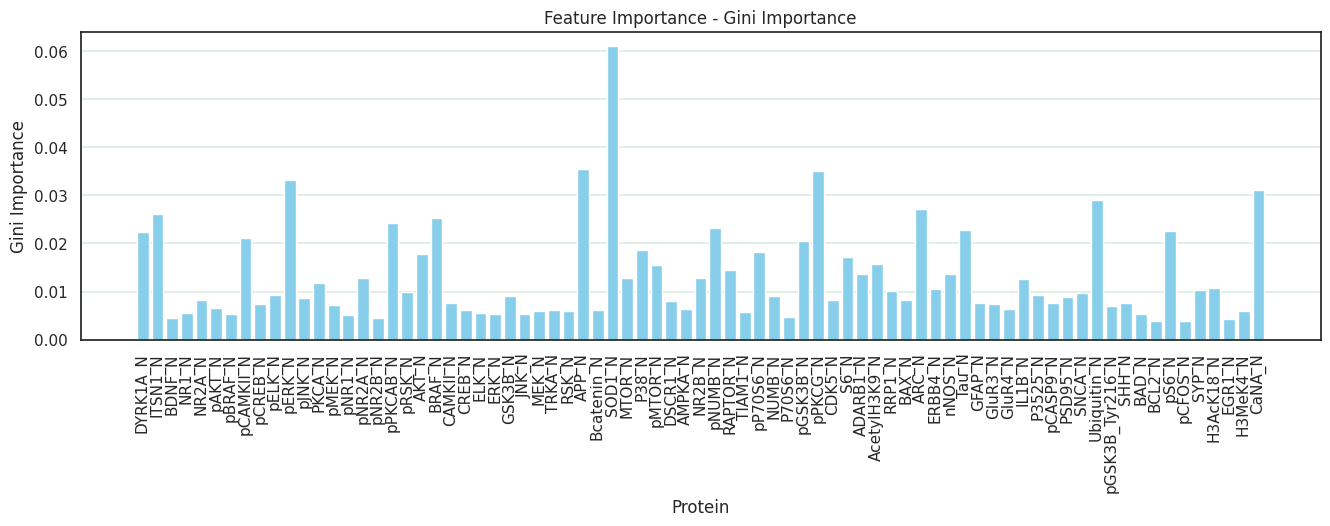

In [40]:
# Create a bar plot for feature importance
plt.figure(figsize=(16, 4))
plt.bar(X_small_train.columns, importances, color='skyblue')
plt.xlabel('Protein')
plt.ylabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca()
plt.xticks(ticks=np.arange(len(X_small_train.columns)),labels=X_small_train.columns,rotation=90)
plt.grid(color='g', linestyle='-', linewidth=0.25, axis='y')
plt.show()

# Plots of important features number and metric aginst cut off

In [41]:
cutOff_list = [0.005, 0.01, 0.02, 0.03, 0.05]
f1_score_list = []
number_of_features = []

for cut_off in cutOff_list:
  selected_features = list(feature_imp_df[feature_imp_df['Gini Importance'] > cut_off]['Feature'].values)
  number_of_features.append(len(selected_features))

  rnd_clf = RandomForestClassifier(random_state=42)
  rnd_clf.fit(X_small_train[selected_features], Y_training.values.flatten())
  y_pred = rnd_clf.predict(X_val[selected_features])
  f1_score_list.append(f1_score(Y_val, y_pred, average='macro'))

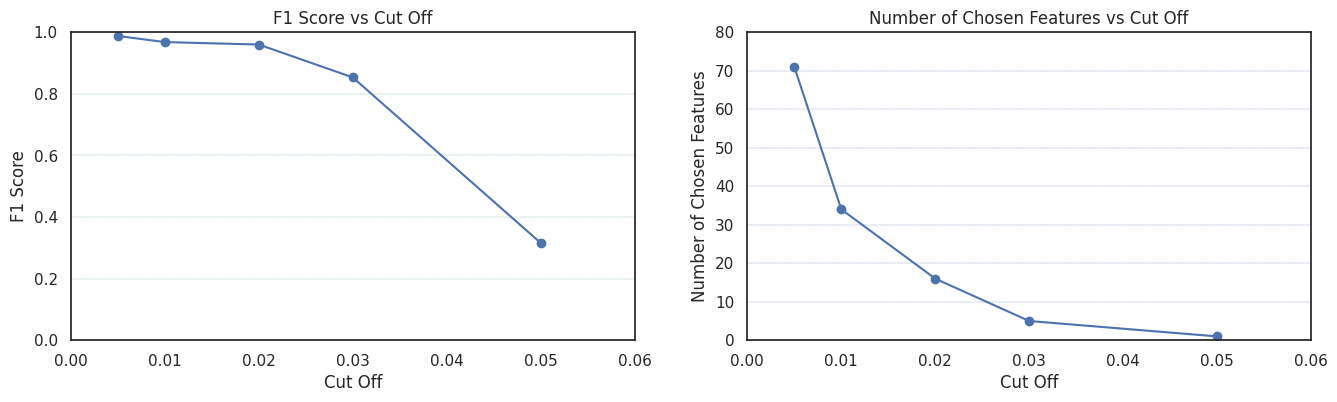

In [42]:
fig, axes =plt.subplots(nrows=1, ncols=2, figsize=(16, 4), sharex=True)

axes[0].plot(cutOff_list, f1_score_list, '-o')
axes[0].set_xlabel('Cut Off')
axes[0].set_ylabel('F1 Score')
axes[0].set_title('F1 Score vs Cut Off')
axes[0].grid(color='g', linestyle='--', linewidth=0.25, axis='y')
axes[0].set_xlim(0, 0.06)
axes[0].set_ylim(0, 1)

axes[1].plot(cutOff_list, number_of_features, '-o')
axes[1].set_xlabel('Cut Off')
axes[1].set_ylabel('Number of Chosen Features')
axes[1].set_title('Number of Chosen Features vs Cut Off')
axes[1].grid(color='b', linestyle='--', linewidth=0.25, axis='y')
axes[1].set_xlim(0, 0.06)
axes[1].set_ylim(0, 80)

plt.show()

When cut_off=0.2, F1 score is greater than 0.9 and number of important features is less than 20, thus this cut off is a good one.

In [43]:
selected_features = list(feature_imp_df[feature_imp_df['Gini Importance'] > 0.02]['Feature'].values)

In [ ]:
print(len(selected_features))
print(selected_features)

16
['SOD1_N', 'APP_N', 'pPKCG_N', 'pERK_N', 'CaNA_N', 'Ubiquitin_N', 'ARC_N', 'ITSN1_N', 'BRAF_N', 'pPKCAB_N', 'pNUMB_N', 'Tau_N', 'pS6_N', 'DYRK1A_N', 'pCAMKII_N', 'pGSK3B_N']


# Random Forest (baseline and tuned model)

Baseline

In [44]:
# Baseline
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(X_small_train[selected_features], Y_training.values.flatten())
y_pred_onVal_baseline = rnd_clf.predict(X_val[selected_features])

In [64]:
rnd_clf

RandomForestClassifier(random_state=42)

In [45]:
from sklearn.preprocessing import label_binarize

# You need the labels to binarize
labels = list(Y_val['class'].value_counts().index)

# Binarize ytest with shape (n_samples, n_classes)
Y_val_new = label_binarize(Y_val, classes=labels)

# Binarize ypreds with shape (n_samples, n_classes)
y_pred_onVal_baseline_new = label_binarize(y_pred_onVal_baseline, classes=labels)

In [46]:
metrics_rfChosenFeatures_onVal_baseline = pd.DataFrame({
    'accuracy': [accuracy_score(Y_val, y_pred_onVal_baseline)],
    'precision': [precision_score(Y_val, y_pred_onVal_baseline, average='macro')],
    'recall': [recall_score(Y_val, y_pred_onVal_baseline, average='macro')],
    'f1_score': [f1_score(Y_val, y_pred_onVal_baseline, average='macro')],
    'roc_auc': roc_auc_score(Y_val_new, y_pred_onVal_baseline_new, average='macro', multi_class='ovr')
}, index = ['metrics_rfChosenFeatures_onVal_baseline'])

metrics_rfChosenFeatures_onVal_baseline

accuracy  precision    recall  \
metrics_rfChosenFeatures_onVal_baseline   0.95858   0.960136  0.960565   

                                         f1_score   roc_auc  
metrics_rfChosenFeatures_onVal_baseline  0.960093  0.977309

In [47]:
confusion_matrix(Y_val, y_pred_onVal_baseline)

array([[22,  1,  0,  0,  1,  0,  0,  0],
       [ 0, 21,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 23,  0,  0,  0,  1,  0],
       [ 0,  0,  0, 20,  0,  0,  1,  0],
       [ 1,  0,  0,  0, 20,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 16,  0,  0],
       [ 0,  0,  1,  0,  0,  0, 19,  1],
       [ 0,  0,  0,  0,  0,  0,  0, 21]])

#Tune Random Forest

In [48]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [49]:
from sklearn.model_selection import cross_val_score

In [79]:
random.seed = 42

space = {
    'n_estimators': hp.uniform('n_estimators', 1, 100),
    'max_depth': hp.uniform('max_depth', 1, 10),
    'min_samples_split': hp.uniform('min_samples_split', 2, 5),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 1, 5)
    }

In [80]:
def objective_chosenFea(space):
  rf_clf = RandomForestClassifier(
      n_estimators = int(space['n_estimators']),
      max_depth = int(space['max_depth']),
      min_samples_split = int(space['min_samples_split']),
      min_samples_leaf = int(space['min_samples_leaf']),
      random_state = 42
      )

  return_val = cross_val_score(rf_clf, X_small_train[selected_features], Y_training.values.flatten(),  cv=3, scoring='f1_macro')
  to_return = 1 - return_val.mean()
  return {'loss':to_return, 'status': STATUS_OK }

In [81]:
%%time

trials = Trials()

best_hyperparams_chosenFea = fmin(fn = objective_chosenFea,
                                  space = space,
                                  algo = tpe.suggest,
                                  max_evals = 20, # set it to 20 here
                                  rstate=np.random.default_rng(42),
                                  trials = trials)

100%|██████████| 20/20 [00:08<00:00,  2.46trial/s, best loss: 0.099453839724856]
CPU times: user 7.97 s, sys: 33.8 ms, total: 8.01 s
Wall time: 8.12 s


In [82]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams_chosenFea)

The best hyperparameters are :  

{'max_depth': 8.824203246567754, 'min_samples_leaf': 1.3269877678086233, 'min_samples_split': 4.990961629700317, 'n_estimators': 70.20878087940932}


In [83]:
%%time
from tqdm.notebook import tqdm

# to create a learning curve
def plot_learning_curve(model, X_train, y_train, X_val, y_val, M):
    train_errors, val_errors = [], []
    for m in tqdm(range(1, len(X_train), M)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(f1_score(y_train[:m], y_train_predict, average='macro'))
        val_errors.append(f1_score(y_val, y_val_predict, average='macro'))
    plt.figure(figsize=(12,6))
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel("F1 Score")
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=0.5, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=0.5, label="val")
    plt.grid()
    plt.legend() # in case labels don't show up
    plt.show()

CPU times: user 19 µs, sys: 0 ns, total: 19 µs
Wall time: 24.8 µs


  0%|          | 0/14 [00:00<?, ?it/s]

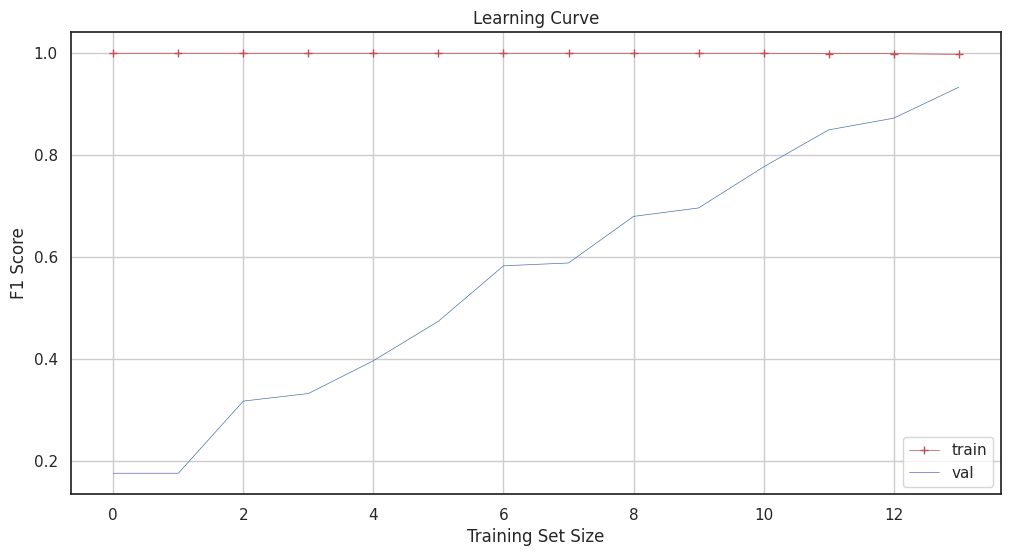

CPU times: user 5.5 s, sys: 91.8 ms, total: 5.59 s
Wall time: 5.72 s


In [84]:
%%time
first_tuned_rf = RandomForestClassifier(
    n_estimators = int(best_hyperparams_chosenFea['n_estimators']),
    max_depth = int(best_hyperparams_chosenFea['max_depth']),
    min_samples_split = int(best_hyperparams_chosenFea['min_samples_split']),
    min_samples_leaf = int(best_hyperparams_chosenFea['min_samples_leaf']),
    random_state=42
)

plot_learning_curve(first_tuned_rf,
                    X_small_train[selected_features],
                    Y_training.values.flatten(),
                    X_val[selected_features],
                    Y_val.values.flatten(), M=50)

In [85]:
first_tuned_rf.fit(X_small_train[selected_features], Y_training.values.flatten())
y_pred_onVal_firstTuned_rf = first_tuned_rf.predict(X_val[selected_features])

In [86]:
y_pred_onVal_firstTuned_rf_new = label_binarize(y_pred_onVal_firstTuned_rf, classes=labels)

In [87]:
metrics_rfChosenFeatures_onVal_firstTuned_rf = pd.DataFrame({
    'accuracy': [accuracy_score(Y_val, y_pred_onVal_firstTuned_rf)],
    'precision': [precision_score(Y_val, y_pred_onVal_firstTuned_rf, average='macro')],
    'recall': [recall_score(Y_val, y_pred_onVal_firstTuned_rf, average='macro')],
    'f1_score': [f1_score(Y_val, y_pred_onVal_firstTuned_rf, average='macro')],
    'roc_auc': roc_auc_score(Y_val_new, y_pred_onVal_firstTuned_rf_new, average='macro', multi_class='ovr')
}, index = ['metrics_rfChosenFeatures_onVal_firstTuned_rf'])

metrics_rfChosenFeatures_onVal_firstTuned_rf

accuracy  precision   recall  \
metrics_rfChosenFeatures_onVal_firstTuned_rf  0.940828   0.943575  0.94494   

                                              f1_score   roc_auc  
metrics_rfChosenFeatures_onVal_firstTuned_rf  0.942173  0.968244

In [88]:
confusion_matrix(Y_val, y_pred_onVal_firstTuned_rf)

array([[19,  4,  0,  0,  1,  0,  0,  0],
       [ 0, 21,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 23,  0,  0,  0,  1,  0],
       [ 0,  0,  0, 20,  0,  0,  1,  0],
       [ 1,  0,  0,  0, 19,  1,  0,  0],
       [ 0,  0,  0,  0,  0, 16,  0,  0],
       [ 0,  0,  1,  0,  0,  0, 20,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 21]])

# Prediction on unseen data

In [89]:
test_prediction_onTest_firstTuned_rf = first_tuned_rf.predict(X_test[selected_features])

In [90]:
# You need the labels to binarize
labels = list(Y_val['class'].value_counts().index)

# Binarize ytest with shape (n_samples, n_classes)
y_test_new = label_binarize(y_test, classes=labels)

# Binarize ypreds with shape (n_samples, n_classes)
test_prediction_onTest_firstTuned_rf_new = label_binarize(test_prediction_onTest_firstTuned_rf, classes=labels)

metrics_rfChosenFeatures_onTest_firstTuned_rf = pd.DataFrame({
    'accuracy': [accuracy_score(y_test, test_prediction_onTest_firstTuned_rf)],
    'precision': [precision_score(y_test, test_prediction_onTest_firstTuned_rf, average='macro')],
    'recall': [recall_score(y_test, test_prediction_onTest_firstTuned_rf, average='macro')],
    'f1_score': [f1_score(y_test, test_prediction_onTest_firstTuned_rf, average='macro')],
    'roc_auc': [roc_auc_score(y_test_new, test_prediction_onTest_firstTuned_rf_new, average='macro', multi_class='ovr')]
}, index = ['metrics_rfChosenFeatures_onTest_firstTuned_rf'])

metrics_rfChosenFeatures_onTest_firstTuned_rf

accuracy  precision    recall  \
metrics_rfChosenFeatures_onTest_firstTuned_rf  0.939815   0.944547  0.939947   

                                               f1_score   roc_auc  
metrics_rfChosenFeatures_onTest_firstTuned_rf  0.940616  0.965653

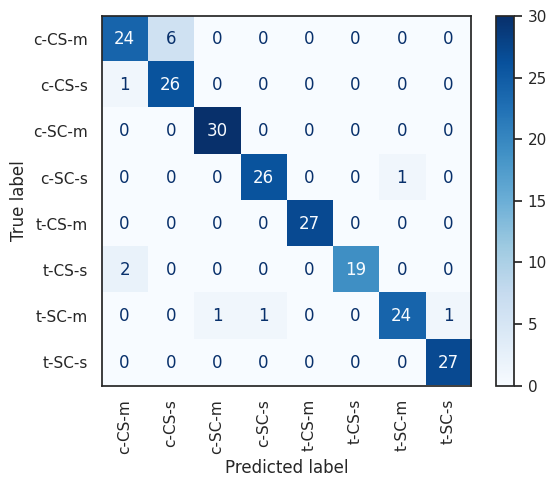

In [91]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, test_prediction_onTest_firstTuned_rf)
cmd = ConfusionMatrixDisplay(cm, display_labels=first_tuned_rf.classes_)
cmd.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

In [92]:
comparison_1 = pd.concat([metrics_rfChosenFeatures_onVal_baseline,
                          metrics_rfChosenFeatures_onVal_firstTuned_rf,
                          metrics_rfChosenFeatures_onTest_firstTuned_rf])

In [93]:
comparison_1

accuracy  precision    recall  \
metrics_rfChosenFeatures_onVal_baseline        0.958580   0.960136  0.960565   
metrics_rfChosenFeatures_onVal_firstTuned_rf   0.940828   0.943575  0.944940   
metrics_rfChosenFeatures_onTest_firstTuned_rf  0.939815   0.944547  0.939947   

                                               f1_score   roc_auc  
metrics_rfChosenFeatures_onVal_baseline        0.960093  0.977309  
metrics_rfChosenFeatures_onVal_firstTuned_rf   0.942173  0.968244  
metrics_rfChosenFeatures_onTest_firstTuned_rf  0.940616  0.965653

# Conclusion:

Now I find the 16 proteins that help classify the target. They are
'SOD1_N', 'APP_N', 'pPKCG_N', 'pERK_N', 'CaNA_N', 'Ubiquitin_N', 'ARC_N', 'ITSN1_N', 'BRAF_N', 'pPKCAB_N', 'pNUMB_N', 'Tau_N', 'pS6_N', 'DYRK1A_N', 'pCAMKII_N', 'pGSK3B_N'.

I am curious whether or not it is better to find a set of linear combination of the original features for prediction.

# What if I don't select important features but use PCA-transformed data?

In [94]:
from sklearn.decomposition import PCA

In [95]:
pca = PCA(n_components=0.95, random_state=42)
pca.fit(X_small_train)
X_train_reduced = pca.transform(X_small_train)
X_val_reduced = pca.transform(X_val)
X_test_reduced = pca.transform(X_test)

In [96]:
X_train_reduced = pd.DataFrame(X_train_reduced, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)])
X_train_reduced

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0   -0.136518  0.940198  0.641900  0.499565 -0.448856  0.064685 -0.042628   
1    1.833402 -1.317349  0.500666 -0.296882 -0.190116  0.244776  0.424478   
2    1.229226 -0.335482  1.159369 -0.129558  0.164618  0.347148  0.202091   
3   -2.450382  0.647914  0.520082 -0.303938 -0.288027 -0.380737 -0.303136   
4    1.719618 -1.211462  0.486521  0.282267  0.105452  0.202767  0.090684   
..        ...       ...       ...       ...       ...       ...       ...   
690 -2.356512 -0.984512 -0.691647  0.442317 -0.554600 -0.340688 -0.216798   
691 -1.080053  1.160013  1.613184 -0.285647  0.045339  0.232580  0.052956   
692  0.498091  0.659992  1.644095 -0.260360  0.040825  0.350322  0.062276   
693  0.290411 -1.608194 -0.286651 -0.031595 -0.269540 -0.135186  0.155336   
694 -1.463545 -1.055552 -0.066356  1.076980  0.031086  0.354744 -0.119142   

          PC8       PC9  
0   -0.080675  0.021959  
1    0.032610  0.208440  
2   -0.130410  0.171809  
3   -0.016563  0.021045  
4    0.548372  0.079694  
..        ...       ...  
690  0.345017 -0.007011  
691 -0.004183 -0.133507  
692  0.164644 -0.175595  
693  0.482794  0.040257  
694  0.101916 -0.181908  

[695 rows x 9 columns]

In [97]:
X_val_reduced = pd.DataFrame(X_val_reduced, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)])
X_val_reduced

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0   -1.138778  0.239733  1.213818 -0.012777  0.047602  0.011280  0.279136   
1   -2.331369 -0.750113  0.519125 -0.341877 -0.361375 -0.533727 -0.229873   
2   -0.051341  0.103168  0.950060 -0.451830  0.046610  0.005308 -0.365724   
3   -0.041238 -0.053765 -0.868606  0.100468 -0.593376  0.566065 -0.163962   
4   -0.446663 -1.023876 -0.591648 -0.104859 -0.344468  0.284974  0.100988   
..        ...       ...       ...       ...       ...       ...       ...   
164 -1.165836  0.993169  1.885578 -0.295803  0.127128  0.231693  0.256988   
165  2.069036 -0.021099  1.243554 -0.240600  0.312380  0.366749 -0.093738   
166 -2.721071 -0.855861 -0.630830  0.403917 -0.456880  0.057634  0.261317   
167 -0.982086  1.021658  1.727236 -0.141582  0.149588  0.153962  0.211849   
168 -1.190658 -0.114713  1.199731 -0.458179  0.359930 -0.062514 -0.314137   

          PC8       PC9  
0   -0.227017  0.059310  
1   -0.318542  0.002915  
2    0.037705 -0.176853  
3   -0.006370 -0.075007  
4   -0.116183 -0.231522  
..        ...       ...  
164  0.059841 -0.146559  
165  0.338993 -0.232271  
166  0.146155  0.068854  
167  0.088023 -0.259982  
168  0.163947  0.453207  

[169 rows x 9 columns]

In [98]:
X_test_reduced = pd.DataFrame(X_test_reduced, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)])
X_test_reduced

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0    0.962214 -2.460055  0.030523 -0.558805 -0.165509 -0.340910 -0.433545   
1    0.036808 -1.856149  0.303800 -0.392764 -0.334732 -0.498280 -0.267564   
2   -0.208933 -1.698292  0.335676 -0.442040 -0.277542 -0.293228 -0.274365   
3   -0.159314 -1.738289  0.298507 -0.440301 -0.291376 -0.309638 -0.416218   
4   -0.805533 -1.313174  0.385379 -0.371070 -0.273965 -0.465444 -0.247958   
..        ...       ...       ...       ...       ...       ...       ...   
211  3.898420  1.328888  0.641299 -0.099568 -0.296845 -0.127851 -0.003586   
212  2.570431  1.718179  0.776117  0.023360 -0.224642 -0.170993  0.005405   
213 -1.069300  0.878567  0.827833 -0.598066  0.648750 -0.441744 -0.316821   
214 -1.533897  0.940970  0.773059 -0.531941  0.564458 -0.445401 -0.183511   
215 -2.040188  0.498235  0.644555 -0.562161  0.783286 -0.173497 -0.022873   

          PC8       PC9  
0   -0.242536 -0.001187  
1   -0.358879 -0.090858  
2   -0.308965 -0.065446  
3   -0.352166 -0.070795  
4   -0.360684 -0.035063  
..        ...       ...  
211  0.314570 -0.103214  
212  0.103829 -0.114193  
213  0.008549  0.101597  
214 -0.034232  0.047224  
215 -0.188671  0.166665  

[216 rows x 9 columns]

In [99]:
# Baseline
randomForest_pcaTr = RandomForestClassifier(random_state=42)
randomForest_pcaTr.fit(X_train_reduced, Y_training.values.flatten())
y_pred_onVal_pcaTr_baseline = randomForest_pcaTr.predict(X_val_reduced)

In [100]:
# Binarize ypreds with shape (n_samples, n_classes)
y_pred_onVal_pcaTr_baseline_new = label_binarize(y_pred_onVal_pcaTr_baseline, classes=labels)

In [101]:
metrics_pcaTr_onVal_baseline = pd.DataFrame({
    'accuracy': [accuracy_score(Y_val, y_pred_onVal_pcaTr_baseline)],
    'precision': [precision_score(Y_val, y_pred_onVal_pcaTr_baseline, average='macro')],
    'recall': [recall_score(Y_val, y_pred_onVal_pcaTr_baseline, average='macro')],
    'f1_score': [f1_score(Y_val, y_pred_onVal_pcaTr_baseline, average='macro')],
    'roc_auc': roc_auc_score(Y_val_new, y_pred_onVal_pcaTr_baseline_new, average='macro', multi_class='ovr')
}, index = ['metrics_pcaTr_onVal_baseline'])

metrics_pcaTr_onVal_baseline

accuracy  precision   recall  f1_score   roc_auc
metrics_pcaTr_onVal_baseline  0.970414   0.972085  0.97247  0.972167  0.984106

In [102]:
confusion_matrix(Y_val, y_pred_onVal_pcaTr_baseline)

array([[24,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 21,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 21,  0,  0,  0,  3,  0],
       [ 0,  0,  0, 21,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 21,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 16,  0,  0],
       [ 0,  0,  2,  0,  0,  0, 19,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 21]])

#Tune Random Forest

In [103]:
random.seed = 42

space = {
    'n_estimators': hp.uniform('n_estimators', 1, 100),
    'max_depth': hp.uniform('max_depth', 1, 10),
    'min_samples_split': hp.uniform('min_samples_split', 2, 5),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 1, 5)
    }

In [104]:
def objective_pcaTr(space):
  rf_clf = RandomForestClassifier(
      n_estimators = int(space['n_estimators']),
      max_depth = int(space['max_depth']),
      min_samples_split = int(space['min_samples_split']),
      min_samples_leaf = int(space['min_samples_leaf']),
      random_state = 42
      )

  return_val = cross_val_score(rf_clf, X_train_reduced, Y_training.values.flatten(),  cv=3, scoring='f1_macro')
  to_return = 1 - return_val.mean()
  return {'loss':to_return, 'status': STATUS_OK }

In [105]:
%%time

trials = Trials()

best_hyperparams_pcaTr = fmin(fn = objective_pcaTr,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 20, # set it to 20 here
                        rstate=np.random.default_rng(42),
                        trials = trials)

100%|██████████| 20/20 [00:09<00:00,  2.03trial/s, best loss: 0.10905681298667547]
CPU times: user 7.41 s, sys: 50.8 ms, total: 7.46 s
Wall time: 9.87 s


In [106]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams_pcaTr)

The best hyperparameters are :  

{'max_depth': 8.824203246567754, 'min_samples_leaf': 1.3269877678086233, 'min_samples_split': 4.990961629700317, 'n_estimators': 70.20878087940932}


  0%|          | 0/14 [00:00<?, ?it/s]

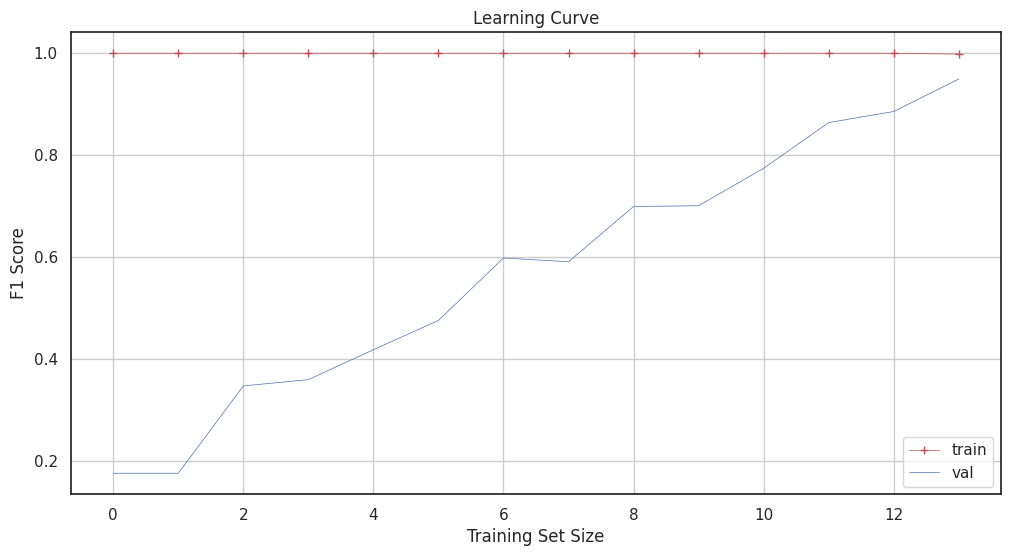

CPU times: user 4.26 s, sys: 151 ms, total: 4.41 s
Wall time: 4.3 s


In [107]:
%%time
secoond_tuned_rf = RandomForestClassifier(
    n_estimators = int(best_hyperparams_pcaTr['n_estimators']),
    max_depth = int(best_hyperparams_pcaTr['max_depth']),
    min_samples_split = int(best_hyperparams_pcaTr['min_samples_split']),
    min_samples_leaf = int(best_hyperparams_pcaTr['min_samples_leaf']),
    random_state=42
)

plot_learning_curve(secoond_tuned_rf, X_train_reduced, Y_training.values.flatten(), X_val_reduced, Y_val.values.flatten(), M=50)

In [108]:
second_tuned_rf = RandomForestClassifier(
    n_estimators = int(best_hyperparams_pcaTr['n_estimators']),
    max_depth = int(best_hyperparams_pcaTr['max_depth']),
    min_samples_split = int(best_hyperparams_pcaTr['min_samples_split']),
    min_samples_leaf = int(best_hyperparams_pcaTr['min_samples_leaf']),
    random_state=42
)

second_tuned_rf.fit(X_train_reduced, Y_training.values.flatten())
y_pred_onVal_secondTuned_rf = second_tuned_rf.predict(X_val_reduced)

In [109]:
y_pred_onVal_secondTuned_rf_new = label_binarize(y_pred_onVal_secondTuned_rf, classes=labels)

In [110]:
metrics_pcaTr_onVal_secondTuned_rf = pd.DataFrame({
    'accuracy': [accuracy_score(Y_val, y_pred_onVal_secondTuned_rf)],
    'precision': [precision_score(Y_val, y_pred_onVal_secondTuned_rf, average='macro')],
    'recall': [recall_score(Y_val, y_pred_onVal_secondTuned_rf, average='macro')],
    'f1_score': [f1_score(Y_val, y_pred_onVal_secondTuned_rf, average='macro')],
    'roc_auc': roc_auc_score(Y_val_new, y_pred_onVal_secondTuned_rf_new , average='macro', multi_class='ovr')
}, index = ['metrics_pcaTr_onVal_secondTuned_rf'])

metrics_pcaTr_onVal_secondTuned_rf

accuracy  precision   recall  f1_score  \
metrics_pcaTr_onVal_secondTuned_rf  0.940828   0.942252  0.94494  0.942949   

                                     roc_auc  
metrics_pcaTr_onVal_secondTuned_rf  0.968235

In [111]:
confusion_matrix(Y_val, y_pred_onVal_secondTuned_rf)

array([[22,  0,  0,  0,  0,  1,  0,  1],
       [ 0, 21,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 20,  0,  0,  0,  4,  0],
       [ 0,  0,  0, 21,  0,  0,  0,  0],
       [ 0,  1,  0,  0, 20,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 16,  0,  0],
       [ 0,  0,  3,  0,  0,  0, 18,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 21]])

# Prediction on unseen data

In [112]:
test_prediction_onTest_secondTuned_rf = second_tuned_rf.predict(X_test_reduced)

In [113]:
# You need the labels to binarize
labels = list(Y_val['class'].value_counts().index)

# Binarize ytest with shape (n_samples, n_classes)
y_test_new = label_binarize(y_test, classes=labels)

# Binarize ypreds with shape (n_samples, n_classes)
test_prediction_onTest_secondTuned_rf_new = label_binarize(test_prediction_onTest_secondTuned_rf, classes=labels)

metrics_pcaTr_onTest_secondTuned_rf = pd.DataFrame({
    'accuracy': [accuracy_score(y_test, test_prediction_onTest_secondTuned_rf)],
    'precision': [precision_score(y_test, test_prediction_onTest_secondTuned_rf, average='macro')],
    'recall': [recall_score(y_test, test_prediction_onTest_secondTuned_rf, average='macro')],
    'f1_score': [f1_score(y_test, test_prediction_onTest_secondTuned_rf, average='macro')],
    'roc_auc': [roc_auc_score(y_test_new, test_prediction_onTest_secondTuned_rf_new, average='macro', multi_class='ovr')]
}, index = ['metrics_pcaTr_onTest_secondTuned_rf'])

metrics_pcaTr_onTest_secondTuned_rf

accuracy  precision    recall  f1_score  \
metrics_pcaTr_onTest_secondTuned_rf  0.930556    0.93129  0.932011   0.93105   

                                      roc_auc  
metrics_pcaTr_onTest_secondTuned_rf  0.961028

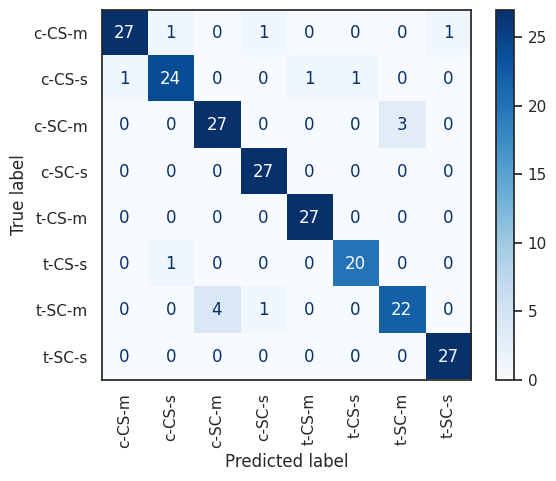

In [114]:
cm_2 = confusion_matrix(y_test, test_prediction_onTest_secondTuned_rf)
cmd_2 = ConfusionMatrixDisplay(cm_2, display_labels=second_tuned_rf.classes_)
cmd_2.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

In [115]:
comparison_2 = pd.concat([metrics_pcaTr_onVal_baseline,
                          metrics_pcaTr_onVal_secondTuned_rf,
                          metrics_pcaTr_onTest_secondTuned_rf])

comparison_2

accuracy  precision    recall  f1_score  \
metrics_pcaTr_onVal_baseline         0.970414   0.972085  0.972470  0.972167   
metrics_pcaTr_onVal_secondTuned_rf   0.940828   0.942252  0.944940  0.942949   
metrics_pcaTr_onTest_secondTuned_rf  0.930556   0.931290  0.932011  0.931050   

                                      roc_auc  
metrics_pcaTr_onVal_baseline         0.984106  
metrics_pcaTr_onVal_secondTuned_rf   0.968235  
metrics_pcaTr_onTest_secondTuned_rf  0.961028

In [116]:
comparison_table = pd.concat([comparison_1, comparison_2])
comparison_table

accuracy  precision    recall  \
metrics_rfChosenFeatures_onVal_baseline        0.958580   0.960136  0.960565   
metrics_rfChosenFeatures_onVal_firstTuned_rf   0.940828   0.943575  0.944940   
metrics_rfChosenFeatures_onTest_firstTuned_rf  0.939815   0.944547  0.939947   
metrics_pcaTr_onVal_baseline                   0.970414   0.972085  0.972470   
metrics_pcaTr_onVal_secondTuned_rf             0.940828   0.942252  0.944940   
metrics_pcaTr_onTest_secondTuned_rf            0.930556   0.931290  0.932011   

                                               f1_score   roc_auc  
metrics_rfChosenFeatures_onVal_baseline        0.960093  0.977309  
metrics_rfChosenFeatures_onVal_firstTuned_rf   0.942173  0.968244  
metrics_rfChosenFeatures_onTest_firstTuned_rf  0.940616  0.965653  
metrics_pcaTr_onVal_baseline                   0.972167  0.984106  
metrics_pcaTr_onVal_secondTuned_rf             0.942949  0.968235  
metrics_pcaTr_onTest_secondTuned_rf            0.931050  0.961028

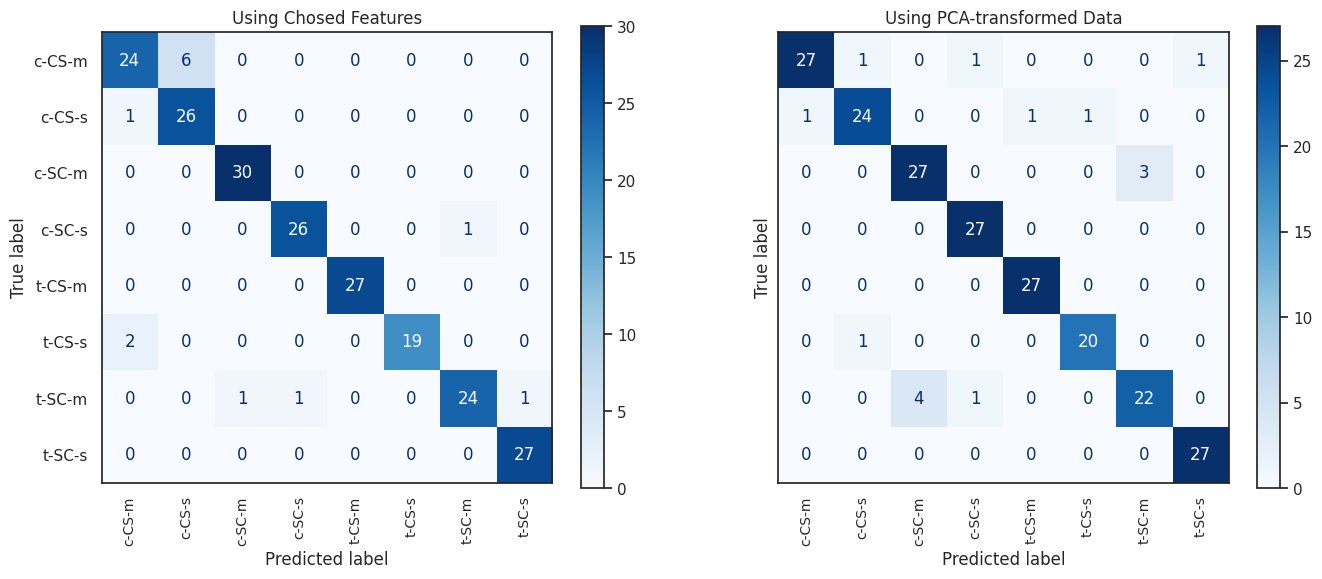

In [117]:
fig, axes =plt.subplots(nrows=1, ncols=2, figsize=(16, 6), sharex=True, sharey=True)

cmd.plot(cmap=plt.cm.Blues, ax=axes[0])
axes[0].tick_params(axis='x', labelsize='small', rotation=90)
axes[0].set_title('Using Chosed Features')

cmd_2.plot(cmap=plt.cm.Blues, ax=axes[1])
axes[1].tick_params(axis='x', labelsize='small', rotation=90)
axes[1].set_title('Using PCA-transformed Data')

plt.show()

In [118]:
cm.diagonal().sum()

203

In [119]:
cm_2.diagonal().sum()

201

The comparison show that the two strategies are not significantly different. The advantage of the first strategy is that the chosen model can tell which protein contributes to distiguishing the classes in the target column.